# Guitar effect

## 1. Load classes, define functions...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.constants as const
import scipy
import time as timeclass
import numpy as np
import base64
from scipy.io import wavfile
from IPython.core.display import HTML

# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
def wavPlayer(filepath):
    # Base on: https://nbviewer.org/gist/Carreau/5507501/the%20sound%20of%20hydrogen.ipynb
    with open(filepath,"rb") as inFile:
        baseData = base64.b64encode(inFile.read()).decode("utf-8")
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="data:audio/wav;base64,%s" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(baseData)
    display(HTML(src))


## 2. Load input file
change the "INPUT_WAVE" constant to load a different example

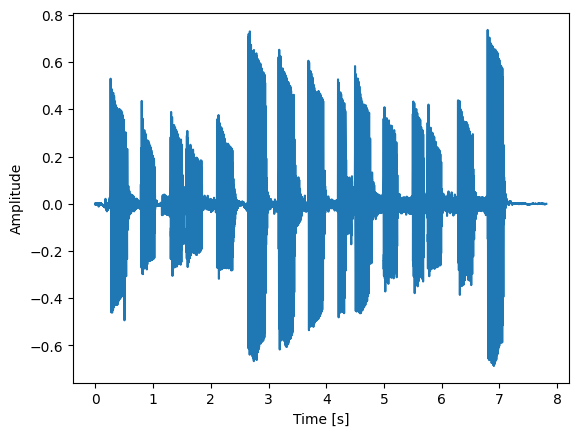

In [2]:
INPUT_WAVE = "lick2.wav"
samplerate, inputsamples = scipy.io.wavfile.read(INPUT_WAVE)
inputsamples = inputsamples / 32768.0
length = inputsamples.shape[0] / samplerate
time = np.linspace(0., length, inputsamples.shape[0])
plt.plot(time, inputsamples)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()
wavPlayer(INPUT_WAVE)

## 3. Define the effect -- Change the Code here to design your own effect.

In MATLAB, filter values can be found with code similar to the following:

```
fs = 48000
f = [0 0.1 0.11 0.2 0.2 1]; 
m = [0 0 1 1 0 0];
[b,a] = yulewalk(8,f,m)
freqz(b,a,[],fs)
```

In [3]:
# IIR Filter
# Eingabe: die letzten 1024 samples (Nummer 0 ist der aktuell, Nummer 1 der davor, ...)
round  = 0
dir = 0
a = [1.0000 ,  -6.3152 ,  18.2993 , -31.6457 ,  35.6404 , -26.7346 ,  13.0400 ,  -3.7838 ,   0.5012]
b = [0.0067 ,  -0.0216 ,   0.0273 ,  -0.0084 ,  -0.0209 ,   0.0321 ,  -0.0221 ,   0.0080 ,-0.0010]
iirFilterHistory = [m*0.0 for m in a]

def effect(history):
    global iirFilterHistory
    nextVal = 0
    iirFilterHistory = [0.0] + iirFilterHistory[0:-1]
    for i,c in enumerate(b):
        nextVal += c*history[i]
    for i,c in enumerate(a):
        if i==0:
            mult = c
        else:
            nextVal -= c*iirFilterHistory[i]
    nextVal *= mult
    iirFilterHistory[0] = nextVal
    return nextVal


## 4. Compute the result and play the output

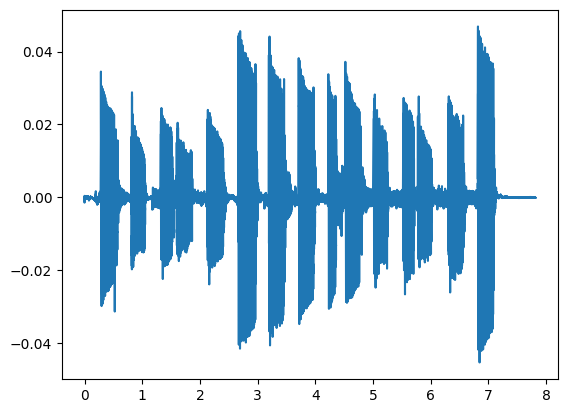

In [4]:
# Effekt ausführen und plotten
outputWave = []
for i in range(0,inputsamples.shape[0]):
    thisHistory = inputsamples[max(i-1024,0):i+1]
    np.flip(thisHistory)
    if i<1024:
        addition = np.full([1024-i-1],inputsamples[0])
        thisHistory = np.concatenate((thisHistory, addition))
    outputWave.append(effect(thisHistory))

# look at it on the first 25 ms
plt.plot(time, outputWave)

# write the file on disk, and show in in a Html 5 audio player
wavfile.write('output.wav', samplerate, (np.array(outputWave)*32768.0).astype(np.int16))
wavPlayer("output.wav")

